Author: Stijn Wijnen

This project has been heavily inspired by https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

# Installing packages and specifying gpu

In [ ]:
import tensorflow as tf
# Verifying GPU availability (you have to turn it on in google colab)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Installing necessary packages
!pip install pytorch-pretrained-bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
% matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

# Loading dataset and applying preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading csv file as df and removing irrelevant / empty (= multiple frames) frames
train_df = pd.read_csv('/content/drive/MyDrive/Studie/Thesis/train_set_verif.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/Studie/Thesis/val_set_verif.csv')

In [ ]:
print(train_df.shape)
print(validation_df.shape)

(1870, 13)
(330, 13)


In [ ]:
# Creating list of comments and corresponding labels
sentences_train = train_df.sentence.values
sentences_val = validation_df.sentence.values
# adding begin and end of sequence tokens that BERT recognises
sentences_train = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_train]
sentences_val = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_val]

# Getting labels           
labels_train = train_df.personal.values
labels_val = validation_df.personal.values

# Getting unique labels 
un_labels = set()
for label in labels_train:
  un_labels.add(label)
print(len(un_labels), un_labels)
# Rewriting labels from str to int so it can be 'understood' by the classifier 
le = preprocessing.LabelEncoder()
le.fit(sorted(un_labels))

labels_train = le.transform(labels_train)
labels_val = le.transform(labels_val)

2 {'Pers', 'NonPers'}


In [ ]:
# Getting BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts_train = [tokenizer.tokenize(sentence) for sentence in sentences_train]
tokenized_texts_val = [tokenizer.tokenize(sentence) for sentence in sentences_val]
# Example of the first comment tokenized
print ("Tokenize the first comment:")
print (tokenized_texts_train[0])

100%|██████████| 231508/231508 [00:00<00:00, 2323513.62B/s]


Tokenize the first comment:
['[CLS]', 'most', 'of', 'the', 'people', 'in', 'america', 'don', "'", 't', 'see', 'a', 'dime', 'of', 'social', 'program', 'money', 'until', 'they', 'turn', '65', ',', 'but', 'they', 'start', 'contributing', 'to', 'them', 'at', '16', '(', 'or', 'whenever', 'they', 'get', 'their', 'first', 'job', ')', '.', '[SEP]']


In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_train]
input_ids_val = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_val]

In [ ]:
# Pad our input tokens
input_ids_train = pad_sequences(input_ids_train, maxlen=305, dtype="long", truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val, maxlen=305, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks_train = []
attention_masks_val = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_train:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_train.append(seq_mask)

for seq in input_ids_val:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_val.append(seq_mask)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(input_ids_train)
validation_inputs = torch.tensor(input_ids_val)
train_labels = torch.tensor(labels_train)
validation_labels = torch.tensor(labels_val)
train_masks = torch.tensor(attention_masks_train)
validation_masks = torch.tensor(attention_masks_val)

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 8

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Making model ready for training

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 407873900/407873900 [00:07<00:00, 58214395.20B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training the model

In [ ]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.2374354305768656


Epoch:  25%|██▌       | 1/4 [02:10<06:32, 130.69s/it]

Validation Accuracy: 0.9196428571428571
Train loss: 0.10441028278019542


Epoch:  50%|█████     | 2/4 [04:29<04:30, 135.40s/it]

Validation Accuracy: 0.9464285714285714
Train loss: 0.02609638785485688


Epoch:  75%|███████▌  | 3/4 [06:48<02:17, 137.25s/it]

Validation Accuracy: 0.9464285714285714
Train loss: 0.00890758860331182


Epoch: 100%|██████████| 4/4 [09:08<00:00, 137.11s/it]

Validation Accuracy: 0.9613095238095238


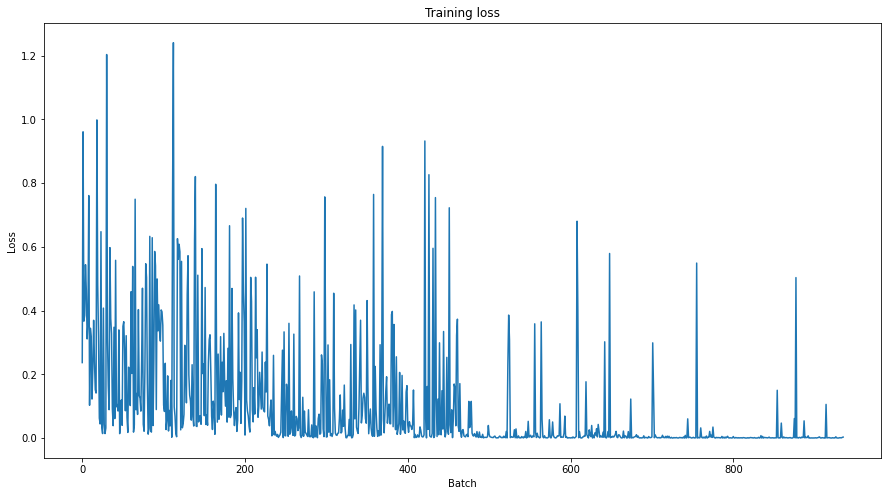

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# Testing the model on test set

In [ ]:
# Importing and processing test data
test_df = pd.read_csv('/content/drive/MyDrive/Studie/Thesis/test_set_verif.csv')
sentences_test = test_df.sentence.values
sentences_test = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_test]
labels_test = test_df.personal.values
labels_test = le.transform(labels_test)

tokenized_texts_test = [tokenizer.tokenize(sentence) for sentence in sentences_test]

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
# Pad our input tokens
input_ids_test = pad_sequences(input_ids_test, maxlen=305, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks_test = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels_test)

batch_size = 8

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)


In [ ]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [ ]:
print(matthews_set)

[0.0, 0.6546536707079772, 0.7745966692414834, 0.7745966692414834, 0.6546536707079772, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, -0.2182178902359924, 1.0, 0.6546536707079772, 1.0, 1.0, 0.6546536707079772, 0.7453559924999299, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7453559924999299, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.6546536707079772, 1.0, 1.0, 0.6546536707079772, 0.7453559924999299, 0.7745966692414834, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.6546536707079772, 0.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.0, 0.7745966692414834, 0.7745966692414834, 1.0, 1.0, 0.0, 0.7453559924999299, 0.6324555320336759]


In [ ]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

matthews_corrcoef(flat_true_labels, flat_predictions)

0.833311855130718

In [ ]:
#for i in range(len(flat_true_labels)):
#  print(flat_true_labels[i], flat_predictions[i])
print(len(flat_predictions))
unique, counts = np.unique(flat_predictions, return_counts=True)
#unique, counts = np.unique(flat_true_labels, return_counts=True)
dict(zip(unique, counts))

# 0 = NonArg
# 1 = UnVerif
# 2 = Verif

638


{0: 525, 1: 113}

In [ ]:
def show_plot(cm, labels):
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

        # labels, title and ticks
        ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
        plt.show()

Accuracy: 0.9498432601880877
micro: precision = 0.9498432601880877 	 recall = 0.9498432601880877 	 f1 = 0.9498432601880877
macro: precision = 0.9278550358196376 	 recall = 0.9057499560400915 	 f1 = 0.9162688452515707
weighted: precision = 0.9489893485621286 	 recall = 0.9498432601880877 	 f1 = 0.9491784202883546
Per Class:
NonPers: precision = 0.9619047619047619 	 recall = 0.97678916827853 	 f1 = 0.9692898272552782
Pers: precision = 0.8938053097345132 	 recall = 0.8347107438016529 	 f1 = 0.8632478632478632


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


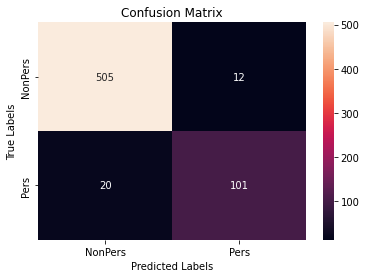

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print("Accuracy: {}".format(accuracy))

macro = precision_recall_fscore_support(flat_true_labels, flat_predictions, average='macro')
micro = precision_recall_fscore_support(flat_true_labels, flat_predictions, average='micro')
weighted = precision_recall_fscore_support(flat_true_labels, flat_predictions, average='weighted')

print("micro: precision = {} \t recall = {} \t f1 = {}".format(micro[0], micro[1], micro[2]))
print("macro: precision = {} \t recall = {} \t f1 = {}".format(macro[0], macro[1], macro[2]))
print("weighted: precision = {} \t recall = {} \t f1 = {}".format(weighted[0], weighted[1], weighted[2]))

per_class = precision_recall_fscore_support(flat_true_labels, flat_predictions, average=None, labels=[0, 1, 2])
print("Per Class:")
print("NonPers: precision = {} \t recall = {} \t f1 = {}".format(per_class[0][0], per_class[1][0], per_class[2][0]))
print("Pers: precision = {} \t recall = {} \t f1 = {}".format(per_class[0][1], per_class[1][1], per_class[2][1]))

cm = confusion_matrix(flat_true_labels, flat_predictions)
show_plot(cm, ['NonPers', 'Pers'])